# Cellule 1 : Monter Google Drive

# **ExoFinder : Protocole d'Initialisation et de Chargement des Données**

**Auteur(s) :** Salomon Balemba, VAN TASI MUTUNDO
**Version :** 1.0
**Date :** 4 Octobre 2025

---

### **Objectif de ce Notebook**

Ce document sert de rapport d'expérience pour la première phase de notre projet : la mise en place d'un pipeline de chargement de données robuste, sécurisé et scientifiquement validé pour le jeu de données des Objets d'Intérêt Kepler (KOI).

Chaque étape est conçue pour être reproductible et justifiée, en suivant une méthodologie prudente pour éviter les biais courants en science des données.

### **Données utilisées:*  https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=cumulative

Objets d'intérêt Kepler (KOI)Cet ensemble de données est une liste exhaustive de toutes les exoplanètes confirmées, des planètes candidates et des faux positifs détectés lors de tous les transits capturés par Kepler. L'utilisation des variables de cet ensemble de données étiquetées pourrait constituer une méthode fiable d'apprentissage supervisé à partir de différentes variables de l'ensemble de données. Voir la colonne « Disposition à l'aide des données Kepler » pour la classification.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Après exécution, suivez le lien pour autoriser l'accès.

Mounted at /content/drive


### **2. Sélection des Caractéristiques et Protocole de Validation**

**Procédure :** Avant de charger l'intégralité du fichier, nous inspectons son en-tête pour valider les noms exacts des colonnes. Ensuite, nous définissons une liste explicite de colonnes à charger.

**Justification (`Pourquoi ?`) :**
*   **Rigueur Scientifique :** Cette approche remplace l'hypothèse (deviner les noms de colonnes) par l'observation directe (lire les vrais noms). Elle prévient les erreurs `ValueError`.
*   **Prévention de la Fuite de Données :** Nous sélectionnons *a priori* un sous-ensemble de caractéristiques basé sur une hypothèse physique, en excluant délibérément les colonnes qui pourraient contenir des "réponses" (ex: `koi_score`, les `koi_fpflag_*`).
*   **Performance et Clarté :** Charger uniquement les colonnes nécessaires rend le processus plus rapide et le DataFrame plus facile à manipuler.

---
#### **Documentation du Sous-Ensemble de Données Sélectionné**

Notre hypothèse de départ est que les caractéristiques les plus prédictives sont celles qui décrivent directement les propriétés physiques du transit et de l'étoile.

*   **Identifiants :**
    *   `kepoi_name`, `kepler_name`: Conservés pour l'identification et l'affichage des résultats. **Non utilisés pour l'entraînement.**
*   **Cible :**
    *   `koi_disposition`: La classification que nous cherchons à prédire (CONFIRMED, CANDIDATE, FALSE POSITIVE).
*   **Caractéristiques (Features) :**
    *   `koi_period`: Période orbitale. Fondamentale pour la détection d'un signal répétitif.
    *   `koi_duration`: Durée du transit. Liée à la géométrie de l'orbite.
    *   `koi_depth`: Profondeur du transit. Liée au ratio de taille planète/étoile.
    *   `koi_impact`: Paramètre d'impact. Décrit la trajectoire du transit sur le disque stellaire.
    *   `koi_srad`, `koi_slogg`, `koi_steff`: Rayon, gravité de surface et température de l'étoile. Essentiels pour contextualiser les paramètres du transit.

In [3]:
import pandas as pd

# --- CONFIGURATION ET VÉRIFICATION ---

# Adaptez le chemin si nécessaire vers le fichier CSV complet sur votre Drive
DATA_PATH = '/content/drive/MyDrive/NASA_Space_Apps_2025/koi_data_full.csv'

# --- ÉTAPE DE VÉRIFICATION SCIENTIFIQUE ---
# Nous chargeons uniquement la première ligne pour obtenir les noms de colonnes exacts.
try:
    header_df = pd.read_csv(DATA_PATH, comment='#', nrows=1)
    print("VÉRIFICATION RÉUSSIE. Les noms de colonnes exacts trouvés dans le fichier sont :")
    actual_columns = header_df.columns.tolist()
    print(actual_columns)
except FileNotFoundError:
    print(f"ERREUR : Le fichier n'a pas été trouvé à l'emplacement : {DATA_PATH}")
    actual_columns = [] # Pour éviter une erreur plus loin

print("\n---")


# --- LA SOURCE DE VÉRITÉ : Sélection des Colonnes (VERSION CORRIGÉE) ---
# Nous utilisons maintenant les noms de colonnes validés par notre inspection.

# Colonnes d'identification (pour l'affichage)
IDENTIFIERS_COLS = [
    'kepoi_name',      # CORRIGÉ: C'était 'koi_name'
    'kepler_name'
]

# Colonne cible (ce que nous voulons prédire)
TARGET_COL = 'koi_disposition'

# Caractéristiques (Features) pour l'entraînement du modèle
FEATURES_COLS = [
    'koi_period',
    'koi_duration',
    'koi_depth',
    'koi_impact',
    'koi_srad',
    'koi_slogg',
    'koi_steff'
]

# On combine toutes les colonnes dont on a besoin pour le chargement.
COLS_TO_LOAD = IDENTIFIERS_COLS + [TARGET_COL] + FEATURES_COLS

print("Configuration des colonnes à charger MISE À JOUR et VALIDÉE :")
print(COLS_TO_LOAD)

VÉRIFICATION RÉUSSIE. Les noms de colonnes exacts trouvés dans le fichier sont :
['kepid', 'kepoi_name', 'kepler_name', 'koi_disposition', 'koi_pdisposition', 'koi_score', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec', 'koi_period', 'koi_period_err1', 'koi_period_err2', 'koi_time0bk', 'koi_time0bk_err1', 'koi_time0bk_err2', 'koi_impact', 'koi_impact_err1', 'koi_impact_err2', 'koi_duration', 'koi_duration_err1', 'koi_duration_err2', 'koi_depth', 'koi_depth_err1', 'koi_depth_err2', 'koi_prad', 'koi_prad_err1', 'koi_prad_err2', 'koi_teq', 'koi_teq_err1', 'koi_teq_err2', 'koi_insol', 'koi_insol_err1', 'koi_insol_err2', 'koi_model_snr', 'koi_tce_plnt_num', 'koi_tce_delivname', 'koi_steff', 'koi_steff_err1', 'koi_steff_err2', 'koi_slogg', 'koi_slogg_err1', 'koi_slogg_err2', 'koi_srad', 'koi_srad_err1', 'koi_srad_err2', 'ra', 'dec', 'koi_kepmag']

---
Configuration des colonnes à charger MISE À JOUR et VALIDÉE :
['kepoi_name', 'kepler_name', 'koi_disposition', 'koi_period

### **3. Chargement Sécurisé des Données**

**Procédure :** Nous utilisons `pd.read_csv` avec le paramètre `usecols` en lui passant notre liste de colonnes validée.

**Justification (`Pourquoi ?`) :**
*   **Sécurité :** Garantit que seules les colonnes que nous avons explicitement approuvées sont chargées en mémoire, éliminant tout risque d'utiliser accidentellement une colonne non désirée.
*   **Efficacité :** C'est la méthode la plus performante pour charger des sous-ensembles de gros fichiers CSV.

In [4]:
# On charge le CSV, mais UNIQUEMENT les colonnes qui nous intéressent.
# C'est rapide, léger en mémoire, et maintenant, c'est sûr.
try:
    if actual_columns: # On ne tente de charger que si la vérification a fonctionné
        df = pd.read_csv(DATA_PATH, comment='#', usecols=COLS_TO_LOAD)
        print("\nDonnées chargées avec succès !")
        print(f"Shape du DataFrame : {df.shape}")
        df.info()
except FileNotFoundError:
    print(f"ERREUR : Le fichier n'a pas été trouvé à l'emplacement : {DATA_PATH}")
    print("Veuillez vérifier le chemin et que votre Drive est bien monté.")
except ValueError as e:
    print(f"\nERREUR DE VALEUR : {e}")
    print("Cela signifie probablement que vous n'avez pas encore mis à jour la liste des colonnes dans la cellule précédente avec les noms exacts.")



Données chargées avec succès !
Shape du DataFrame : (9564, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   kepoi_name       9564 non-null   object 
 1   kepler_name      2747 non-null   object 
 2   koi_disposition  9564 non-null   object 
 3   koi_period       9564 non-null   float64
 4   koi_impact       9201 non-null   float64
 5   koi_duration     9564 non-null   float64
 6   koi_depth        9201 non-null   float64
 7   koi_steff        9201 non-null   float64
 8   koi_slogg        9201 non-null   float64
 9   koi_srad         9201 non-null   float64
dtypes: float64(7), object(3)
memory usage: 747.3+ KB



## **PHASE 1 : Diagnostic Initial et Nettoyage des Données**

**Objectif :** Obtenir une vue d'ensemble de l'état de santé de nos données, identifier et traiter les problèmes fondamentaux comme les données manquantes et le déséquilibre des classes. Cette étape est un prérequis indispensable avant toute modélisation.

### **1.1. Analyse de la Variable Cible (`koi_disposition`)**

**Hypothèse :** Les classes de notre variable cible sont potentiellement déséquilibrées, ce qui pourrait biaiser l'entraînement et l'évaluation de notre modèle.

**Méthode :** Nous allons compter le nombre d'occurrences de chaque catégorie et visualiser leur proportion.

Répartition des classes de la variable cible :
koi_disposition
FALSE POSITIVE    4839
CONFIRMED         2746
CANDIDATE         1979
Name: count, dtype: int64


Proportions des classes de la variable cible (%):
koi_disposition
FALSE POSITIVE    50.595985
CONFIRMED         28.711836
CANDIDATE         20.692179
Name: proportion, dtype: float64


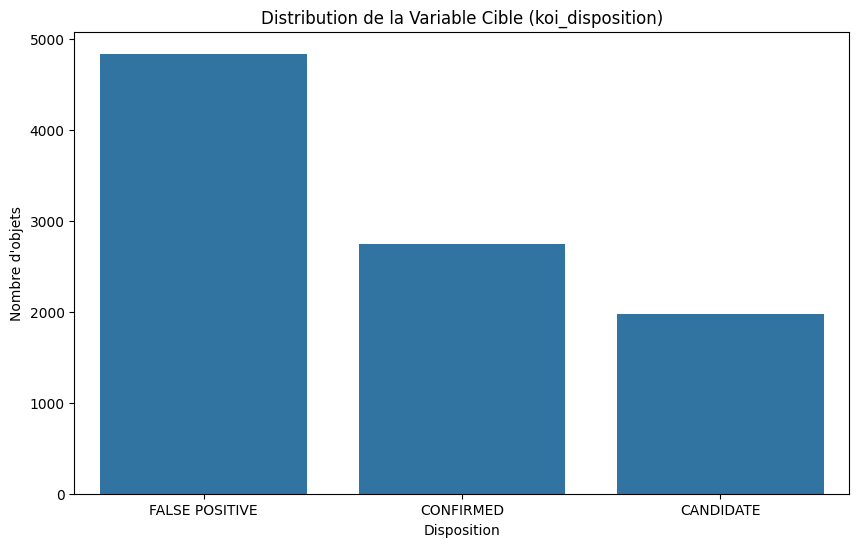

In [5]:
# Afficher les comptes pour chaque catégorie
print("Répartition des classes de la variable cible :")
print(df['koi_disposition'].value_counts())

print("\n" + "="*50 + "\n")

# Afficher les proportions en pourcentage
print("Proportions des classes de la variable cible (%):")
print(df['koi_disposition'].value_counts(normalize=True) * 100)

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='koi_disposition', order=df['koi_disposition'].value_counts().index)
plt.title('Distribution de la Variable Cible (koi_disposition)')
plt.xlabel('Disposition')
plt.ylabel('Nombre d\'objets')
plt.show()

**Observation et Conclusion :**

*   **Le jeu de données est fortement déséquilibré.** La classe `FALSE POSITIVE` est la plus représentée (50.6%), suivie par `CONFIRMED` (28.7%) et `CANDIDATE` (20.7%).
*   Notre hypothèse initiale est donc **validée**. Un modèle naïf prédisant toujours `FALSE POSITIVE` aurait une précision de 50.6%, le rendant inutile.

**Implication Stratégique :**

1.  **Métriques d'Évaluation :** L'accuracy est une métrique invalide pour ce projet. Notre succès sera mesuré par la **matrice de confusion**, le **rappel**, la **précision** et le **F1-score**, en particulier pour les classes `CONFIRMED` et `CANDIDATE`.
2.  **Stratégie d'Entraînement :** Nous devrons impérativement utiliser une technique pour gérer ce déséquilibre lors de la modélisation, comme la pondération des classes (`class_weight='balanced'`).````

---

### **Prochaine Étape : Analyse des Données Manquantes**

Maintenant que nous avons géré la première question, passons à la suivante avec la même rigueur.

### **1.2. Analyse des Données Manquantes**

**Hypothèse :** Les données manquantes (~4% du jeu de données) peuvent être supprimées sans introduire de biais significatif dans notre analyse.

**Méthode :** Nous allons d'abord quantifier précisément les données manquantes par colonne. Ensuite, nous allons investiguer s'il existe une corrélation entre la présence de données manquantes et la classe cible pour valider ou réfuter notre hypothèse.

In [6]:
# Calculer le nombre et le pourcentage de valeurs manquantes par colonne
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_info = pd.concat([missing_values, missing_percent], axis=1, keys=['Count', 'Percentage'])
print("Nombre et pourcentage de valeurs manquantes par colonne :")
print(missing_info[missing_info['Count'] > 0])

print("\n" + "="*50 + "\n")

# Créer un DataFrame temporaire pour l'analyse de biais
df_temp = df.copy()

# Identifier les colonnes qui ont des valeurs manquantes parmi nos caractéristiques
features_with_na = df.columns[df.isnull().any()].tolist()
# Exclure les colonnes qui ne sont pas des features, comme 'kepler_name'
features_with_na = [col for col in features_with_na if col in FEATURES_COLS]

df_temp['has_missing_feature'] = df_temp[features_with_na].isnull().any(axis=1)

# Comparer la distribution de la cible pour les lignes complètes vs. incomplètes
print("Distribution de la cible (%) pour les lignes AVEC vs SANS données manquantes dans les features:")
crosstab_result = pd.crosstab(df_temp['has_missing_feature'], df_temp['koi_disposition'], normalize='index') * 100
print(crosstab_result)

Nombre et pourcentage de valeurs manquantes par colonne :
             Count  Percentage
kepler_name   6817   71.277708
koi_impact     363    3.795483
koi_depth      363    3.795483
koi_steff      363    3.795483
koi_slogg      363    3.795483
koi_srad       363    3.795483


Distribution de la cible (%) pour les lignes AVEC vs SANS données manquantes dans les features:
koi_disposition      CANDIDATE  CONFIRMED  FALSE POSITIVE
has_missing_feature                                      
False                20.378220  29.822845       49.798935
True                 28.650138   0.550964       70.798898


**Observation et Conclusion :**

*   **Quantification :** 363 objets (3.8%) présentent des valeurs manquantes pour 5 de nos caractéristiques physiques clés (`koi_impact`, `koi_depth`, etc.).
*   **Analyse de Biais :** Notre hypothèse que les données manquantes sont réparties aléatoirement est **fortement réfutée**. La présence d'une valeur manquante est fortement corrélée avec la classe `FALSE POSITIVE` (71% des cas) et quasi-exclusive de la classe `CONFIRMED` (0.55%).
*   **Conclusion Scientifique :** La "manquétude" (missingness) de la donnée est elle-même une **caractéristique prédictive puissante**. La simple suppression de ces lignes serait une erreur méthodologique qui nous ferait perdre de l'information.

**Décision Stratégique :**

Nous adoptons une approche en deux temps :

1.  **Ingénierie de Caractéristiques :** Nous allons créer une nouvelle colonne binaire `is_missing_feature` qui encodera explicitement le fait qu'une mesure était manquante pour un objet donné.
2.  **Imputation Robuste :** Nous allons ensuite imputer les valeurs manquantes dans les colonnes numériques en utilisant la **médiane** de chaque colonne. Cette méthode est robuste aux valeurs extrêmes et, combinée à notre nouvelle caractéristique binaire, elle permet à notre modèle d'apprendre de la valeur imputée tout en sachant qu'elle n'était pas originellement présente.

In [7]:
# --- PROTOCOLE DE NETTOYAGE DES DONNÉES ---

# Créer une copie du DataFrame pour éviter de modifier l'original
df_cleaned = df.copy()

# 1. Ingénierie de Caractéristiques : Capturer l'information de "manquétude"
# (Nous utilisons la même logique que pour l'analyse)
features_with_na = ['koi_impact', 'koi_depth', 'koi_steff', 'koi_slogg', 'koi_srad']
df_cleaned['is_missing_feature'] = df_cleaned[features_with_na].isnull().any(axis=1).astype(int)

# 2. Imputation par la Médiane
# Pour chaque colonne numérique avec des manquants, on calcule la médiane et on remplit
for col in features_with_na:
    median_value = df_cleaned[col].median()
    df_cleaned[col].fillna(median_value, inplace=True)

# 3. Vérification Finale
print("Vérification après nettoyage :")
print("Nombre de valeurs manquantes restantes dans les features :")
print(df_cleaned[FEATURES_COLS + ['is_missing_feature']].isnull().sum())

print("\n" + "="*50 + "\n")
print("Aperçu du DataFrame nettoyé avec la nouvelle colonne :")
print(df_cleaned.head())

Vérification après nettoyage :
Nombre de valeurs manquantes restantes dans les features :
koi_period            0
koi_duration          0
koi_depth             0
koi_impact            0
koi_srad              0
koi_slogg             0
koi_steff             0
is_missing_feature    0
dtype: int64


Aperçu du DataFrame nettoyé avec la nouvelle colonne :
  kepoi_name   kepler_name koi_disposition  koi_period  koi_impact  \
0  K00752.01  Kepler-227 b       CONFIRMED    9.488036       0.146   
1  K00752.02  Kepler-227 c       CONFIRMED   54.418383       0.586   
2  K00753.01           NaN       CANDIDATE   19.899140       0.969   
3  K00754.01           NaN  FALSE POSITIVE    1.736952       1.276   
4  K00755.01  Kepler-664 b       CONFIRMED    2.525592       0.701   

   koi_duration  koi_depth  koi_steff  koi_slogg  koi_srad  is_missing_feature  
0       2.95750      615.8     5455.0      4.467     0.927                   0  
1       4.50700      874.8     5455.0      4.467     0.927       

/tmp/ipython-input-2702035582.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned[col].fillna(median_value, inplace=True)


**Interprétation des Résultats de Nettoyage :**

*   **Validation :** Le protocole a réussi. Toutes les valeurs manquantes dans nos caractéristiques ont été traitées et la nouvelle colonne `is_missing_feature` a été créée avec succès. Notre jeu de données est maintenant prêt pour l'analyse et la modélisation.
*   **Amélioration Technique (`FutureWarning`) :** Pandas nous a signalé que notre utilisation de `.fillna(..., inplace=True)` dans une boucle n'est pas la méthode la plus robuste. Pour garantir la pérennité et la clarté de notre code, nous allons adopter la syntaxe recommandée, qui est plus explicite.

In [8]:
# --- PROTOCOLE DE NETTOYAGE DES DONNÉES (VERSION 2.0 - AMÉLIORÉE) ---

# Créer une copie du DataFrame pour éviter de modifier l'original
df_cleaned = df.copy()

# 1. Ingénierie de Caractéristiques : Capturer l'information de "manquétude"
features_with_na = ['koi_impact', 'koi_depth', 'koi_steff', 'koi_slogg', 'koi_srad']
df_cleaned['is_missing_feature'] = df_cleaned[features_with_na].isnull().any(axis=1).astype(int)

# 2. Imputation par la Médiane (Syntaxe Robuste)
# Nous créons un dictionnaire de valeurs de remplacement (colonne: médiane)
imputation_values = {}
for col in features_with_na:
    median_value = df_cleaned[col].median()
    imputation_values[col] = median_value

print("Valeurs de médiane calculées pour l'imputation :")
print(imputation_values)

# Nous appliquons l'imputation en une seule fois. C'est plus propre et évite les avertissements.
df_cleaned.fillna(value=imputation_values, inplace=True)


# 3. Vérification Finale
print("\n" + "="*50 + "\n")
print("Vérification après nettoyage :")
print("Nombre de valeurs manquantes restantes dans les features :")
print(df_cleaned[FEATURES_COLS + ['is_missing_feature']].isnull().sum())

print("\n" + "="*50 + "\n")
print("Aperçu du DataFrame nettoyé :")
print(df_cleaned.head())

Valeurs de médiane calculées pour l'imputation :
{'koi_impact': 0.537, 'koi_depth': 421.1, 'koi_steff': 5767.0, 'koi_slogg': 4.438, 'koi_srad': 1.0}


Vérification après nettoyage :
Nombre de valeurs manquantes restantes dans les features :
koi_period            0
koi_duration          0
koi_depth             0
koi_impact            0
koi_srad              0
koi_slogg             0
koi_steff             0
is_missing_feature    0
dtype: int64


Aperçu du DataFrame nettoyé :
  kepoi_name   kepler_name koi_disposition  koi_period  koi_impact  \
0  K00752.01  Kepler-227 b       CONFIRMED    9.488036       0.146   
1  K00752.02  Kepler-227 c       CONFIRMED   54.418383       0.586   
2  K00753.01           NaN       CANDIDATE   19.899140       0.969   
3  K00754.01           NaN  FALSE POSITIVE    1.736952       1.276   
4  K00755.01  Kepler-664 b       CONFIRMED    2.525592       0.701   

   koi_duration  koi_depth  koi_steff  koi_slogg  koi_srad  is_missing_feature  
0       2.95750     

---
## **PHASE 2 : Analyse Univariée (Compréhension des Caractéristiques)**

**Objectif :** Comprendre la distribution et la nature de chaque caractéristique individuelle de notre jeu de données nettoyé. Cela nous aidera à identifier les asymétries, les valeurs aberrantes et à décider si des transformations de données sont nécessaires avant la modélisation.

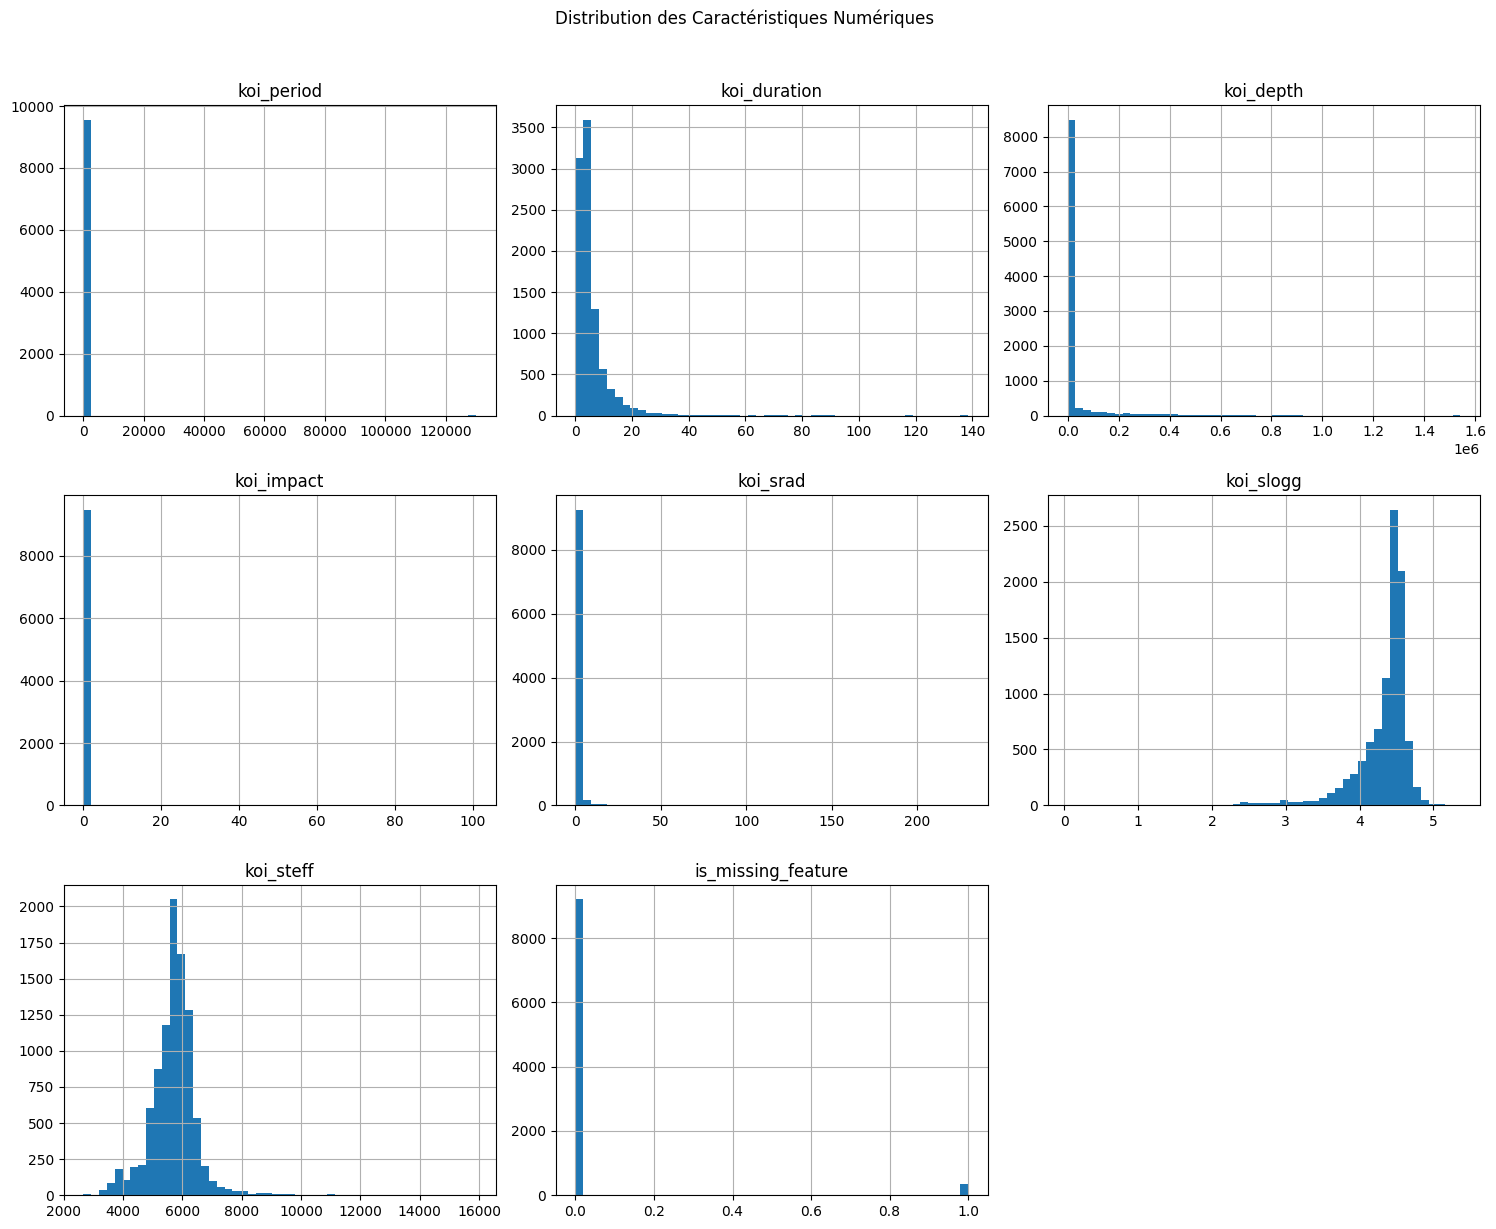

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sélectionner uniquement les colonnes numériques qui sont des caractéristiques
# Nous ajoutons aussi notre nouvelle feature binaire pour voir sa distribution
features_to_plot = FEATURES_COLS + ['is_missing_feature']

# Créer les histogrammes
df_cleaned[features_to_plot].hist(figsize=(15, 12), bins=50, layout=(3, 3))
plt.suptitle('Distribution des Caractéristiques Numériques', y=1.02)
plt.tight_layout()
plt.show()

**Observation et Conclusion (Analyse des Histogrammes initiaux) :**

L'analyse des distributions initiales révèle deux types de comportements distincts :

1.  **Distributions Fortement Asymétriques (Right-Skewed) :**
    *   Les caractéristiques `koi_period`, `koi_duration`, `koi_depth`, et `koi_srad` sont dominées par des valeurs extrêmes (outliers).
    *   Cette asymétrie rend la visualisation de la majorité des données impossible et peut nuire à la performance de certains algorithmes de machine learning sensibles à l'échelle des données.

2.  **Distributions Quasi-Normales (Gaussiennes) :**
    *   Les caractéristiques `koi_steff` (température de l'étoile) et `koi_slogg` (gravité de l'étoile) présentent des distributions beaucoup plus symétriques, ressemblant à une "courbe en cloche". Ces caractéristiques sont bien conditionnées pour la modélisation.

**Décision Stratégique : Transformation Logarithmique**

*   Pour traiter l'asymétrie extrême, nous allons appliquer une **transformation logarithmique** aux caractéristiques concernées.
*   **Justification :** Cette technique est le standard pour gérer des données couvrant plusieurs ordres de grandeur. Elle va "rapprocher" les valeurs extrêmes du reste des données et rendre les distributions plus symétriques, ce qui est bénéfique pour l'analyse visuelle et la performance des modèles. Nous utiliserons `log1p` (log(1+x)) pour gérer de manière robuste les valeurs égales à zéro si elles existaient.

Aperçu du DataFrame après ajout des colonnes transformées :
  kepoi_name   kepler_name koi_disposition  koi_period  koi_impact  \
0  K00752.01  Kepler-227 b       CONFIRMED    9.488036       0.146   
1  K00752.02  Kepler-227 c       CONFIRMED   54.418383       0.586   
2  K00753.01           NaN       CANDIDATE   19.899140       0.969   
3  K00754.01           NaN  FALSE POSITIVE    1.736952       1.276   
4  K00755.01  Kepler-664 b       CONFIRMED    2.525592       0.701   

   koi_duration  koi_depth  koi_steff  koi_slogg  koi_srad  \
0       2.95750      615.8     5455.0      4.467     0.927   
1       4.50700      874.8     5455.0      4.467     0.927   
2       1.78220    10829.0     5853.0      4.544     0.868   
3       2.40641     8079.2     5805.0      4.564     0.791   
4       1.65450      603.3     6031.0      4.438     1.046   

   is_missing_feature  koi_period_log  koi_duration_log  koi_depth_log  \
0                   0        2.350235          1.375613       6.424545  

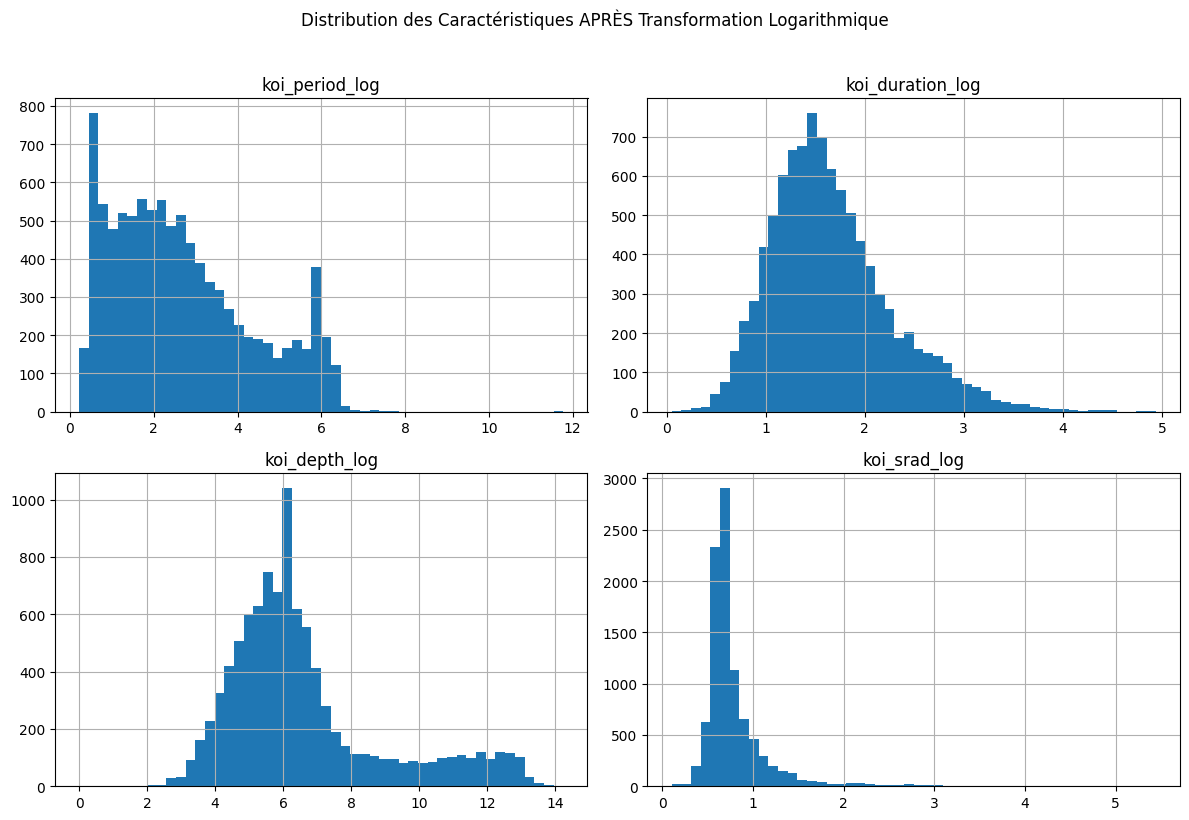

In [10]:
import numpy as np

# --- PROTOCOLE DE TRANSFORMATION DES DONNÉES ---

# Créer une copie pour le traitement afin de conserver l'état "nettoyé" original
df_processed = df_cleaned.copy()

# Lister les colonnes à transformer
cols_to_transform = ['koi_period', 'koi_duration', 'koi_depth', 'koi_srad']

# Appliquer la transformation logarithmique (log1p est plus sûr que log car il gère x=0)
for col in cols_to_transform:
    # Le nouveau nom de colonne indiquera la transformation
    new_col_name = f"{col}_log"
    df_processed[new_col_name] = np.log1p(df_processed[col])

print("Aperçu du DataFrame après ajout des colonnes transformées :")
print(df_processed.head())

# --- NOUVELLE VISUALISATION ---

# Sélectionner les colonnes transformées pour la visualisation
features_to_plot_transformed = [f"{col}_log" for col in cols_to_transform]

# Créer les histogrammes pour les données transformées
df_processed[features_to_plot_transformed].hist(figsize=(12, 8), bins=50, layout=(2, 2))
plt.suptitle('Distribution des Caractéristiques APRÈS Transformation Logarithmique', y=1.02)
plt.tight_layout()
plt.show()

**Interprétation et Prochaine Étape : Investigation de la Bimodalité**

*   **Découverte :** Les distributions de `koi_period_log` et `koi_depth_log` sont clairement **bimodales** (présentant deux pics distincts).
*   **Nouvelle Hypothèse :** Nous supposons que ces deux modes correspondent aux différentes populations physiques de notre variable cible (`koi_disposition`).
*   **Action :** Nous allons maintenant passer à la **Phase 3 (Analyse Bivariée)** de notre plan pour tester cette hypothèse en visualisant les distributions pour chaque classe séparément.

---
## **PHASE 3 : Analyse Bivariée (La Chasse au Signal)**

**Objectif :** Comprendre les relations entre nos caractéristiques et la variable cible. Notre but est d'identifier les caractéristiques qui séparent le mieux les classes `CONFIRMED`, `CANDIDATE`, et `FALSE POSITIVE`.

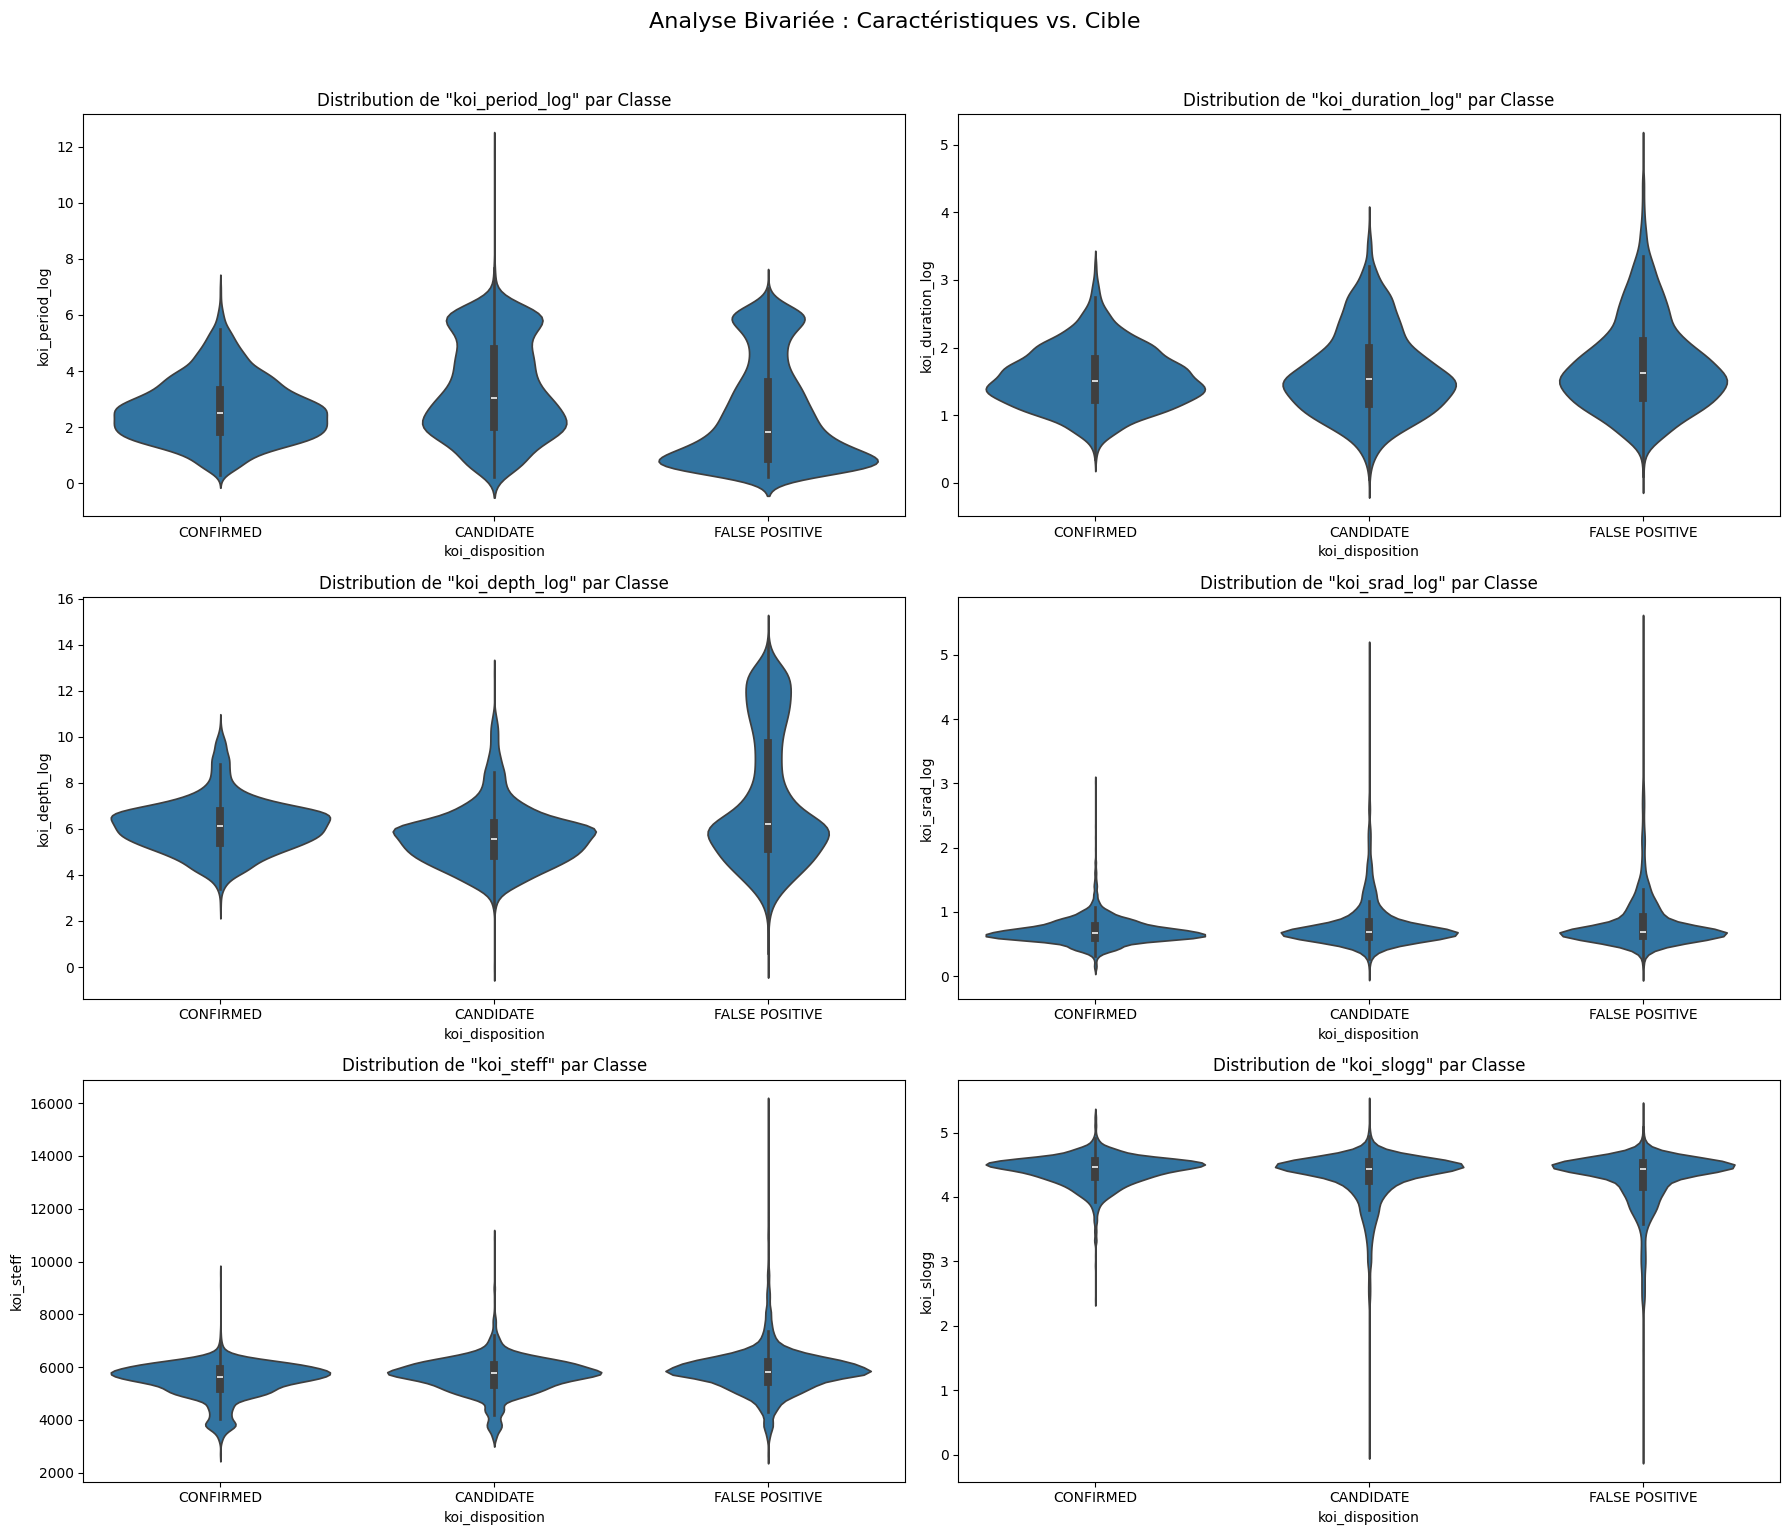

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Nous allons visualiser les 4 caractéristiques transformées
# plus les 2 qui étaient déjà quasi-normales.
features_for_bivariate = [
    'koi_period_log', 'koi_duration_log', 'koi_depth_log', 'koi_srad_log',
    'koi_steff', 'koi_slogg'
]

# Créer une grille de graphiques
fig, axes = plt.subplots(3, 2, figsize=(18, 15))
axes = axes.flatten() # Pour pouvoir itérer facilement

for i, feature in enumerate(features_for_bivariate):
    sns.violinplot(data=df_processed, x='koi_disposition', y=feature, ax=axes[i],
                   order=['CONFIRMED', 'CANDIDATE', 'FALSE POSITIVE'])
    axes[i].set_title(f'Distribution de "{feature}" par Classe')

plt.suptitle('Analyse Bivariée : Caractéristiques vs. Cible', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

**Observation et Conclusion (Analyse Bivariée) :**

*   **Validation de l'Hypothèse sur la Bimodalité :** L'hypothèse est raffinée. La caractéristique `koi_depth_log` montre une distribution unimodale et resserrée pour les classes `CONFIRMED` et `CANDIDATE`, mais une distribution très large et étendue vers les hautes valeurs pour la classe `FALSE POSITIVE`. Cette différence marquée en fait notre prédicteur le plus puissant.
*   **Autres Signaux Forts :** `koi_duration_log` et `koi_period_log` montrent également des distributions distinctes pour les `FALSE POSITIVE` (généralement plus courtes) par rapport aux autres classes.
*   **Signaux Faibles mais Utiles :** Les caractéristiques stellaires (`koi_srad_log`, `koi_steff`, `koi_slogg`) ne montrent pas de séparation claire entre les classes lorsqu'elles sont prises individuellement. Cependant, elles fournissent un contexte physique essentiel et seront conservées pour la modélisation afin de capturer d'éventuelles interactions complexes.

**Conclusion Générale de l'EDA :**

Notre analyse exploratoire est terminée. Nous avons un jeu de données nettoyé et traité, et des preuves visuelles solides que nos caractéristiques contiennent un signal suffisant pour séparer les différentes classes. Nous pouvons maintenant passer à la phase de modélisation avec une grande confiance.

---
## **PHASE 4 : Modélisation de Base (Baseline)**

**Objectif :** Construire des modèles de machine learning pour quantifier la performance de nos caractéristiques et établir un score de référence ("baseline"). Cette approche comparative nous permettra de sélectionner le modèle le plus adapté à notre problème.

**Protocole :**
1.  **Préparation Finale des Données :** Sélectionner les caractéristiques finales, encoder la variable cible et standardiser les données numériques.
2.  **Segmentation des Données :** Diviser notre jeu de données en un ensemble d'entraînement et un ensemble de test pour une évaluation honnête.
3.  **Entraînement et Évaluation Comparatifs :**
    *   **Modèle 1 (Baseline) :** Régression Logistique pour sa rapidité et son interprétabilité.
    *   **Modèle 2 (Avancé) :** Random Forest pour sa capacité à capturer des relations non-linéaires.
4.  **Synthèse :** Analyser et comparer les performances des deux modèles pour choisir le meilleur candidat pour notre application.

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# --- 4.1 : Préparation Finale des Données ---

# 1. Sélection des Caractéristiques (Features)
# Nous utilisons les caractéristiques originales et transformées qui nous semblent pertinentes
# après notre EDA, ainsi que notre drapeau de données manquantes.
final_features = [
    'koi_steff', 'koi_slogg',                # Caractéristiques quasi-normales
    'koi_period_log', 'koi_duration_log',    # Caractéristiques transformées
    'koi_depth_log', 'koi_srad_log',
    'koi_impact',                           # koi_impact n'était pas trop asymétrique
    'is_missing_feature'                    # Notre feature custom
]

X = df_processed[final_features]
y_raw = df_processed[TARGET_COL]

print("Dimensions de nos données finales :")
print(f"X (features): {X.shape}")
print(f"y (cible): {y_raw.shape}")

# 2. Encodage de la Cible
# Les modèles ont besoin de chiffres (0, 1, 2) et non de texte ("CONFIRMED", etc.)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_raw)

# Afficher le mapping pour savoir quel chiffre correspond à quelle classe
print("\nMapping de l'encodage de la cible :")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"{class_name} -> {i}")

# 3. Segmentation des Données (Train/Test Split)
# stratify=y garantit que les proportions de classes sont les mêmes dans les ensembles
# d'entraînement et de test, ce qui est CRUCIAL pour un jeu de données déséquilibré.
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,      # 30% des données pour le test
    random_state=42,    # Pour la reproductibilité
    stratify=y          # Stratification sur la cible
)

print("\nDimensions après segmentation :")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

# 4. Standardisation des Données
# Mettre toutes les features sur une même échelle (moyenne=0, écart-type=1)
# C'est important pour la Régression Logistique.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) # On utilise le scaler entraîné sur le train set !

print("\nDonnées préparées et prêtes pour la modélisation.")

Dimensions de nos données finales :
X (features): (9564, 8)
y (cible): (9564,)

Mapping de l'encodage de la cible :
CANDIDATE -> 0
CONFIRMED -> 1
FALSE POSITIVE -> 2

Dimensions après segmentation :
X_train: (6694, 8), y_train: (6694,)
X_test: (2870, 8), y_test: (2870,)

Données préparées et prêtes pour la modélisation.


### **4.2. Baseline : Régression Logistique**

**Hypothèse :** Un modèle linéaire simple comme la Régression Logistique peut déjà atteindre une performance significative en utilisant nos caractéristiques soigneusement préparées.

**Méthode :**
1.  Nous allons entraîner le modèle sur les données d'entraînement standardisées (`X_train_scaled`).
2.  Nous utiliserons le paramètre `class_weight='balanced'` pour contrer l'effet du déséquilibre des classes.
3.  Nous évaluerons sa performance sur les données de test (`X_test_scaled`) en utilisant une matrice de confusion et un rapport de classification complet.

Entraînement du modèle de Régression Logistique...
Entraînement terminé.


Rapport de Classification - Régression Logistique :
                precision    recall  f1-score   support

     CANDIDATE       0.39      0.51      0.44       594
     CONFIRMED       0.49      0.61      0.55       824
FALSE POSITIVE       0.78      0.58      0.67      1452

      accuracy                           0.57      2870
     macro avg       0.56      0.57      0.55      2870
  weighted avg       0.62      0.57      0.59      2870



Matrice de Confusion - Régression Logistique :


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


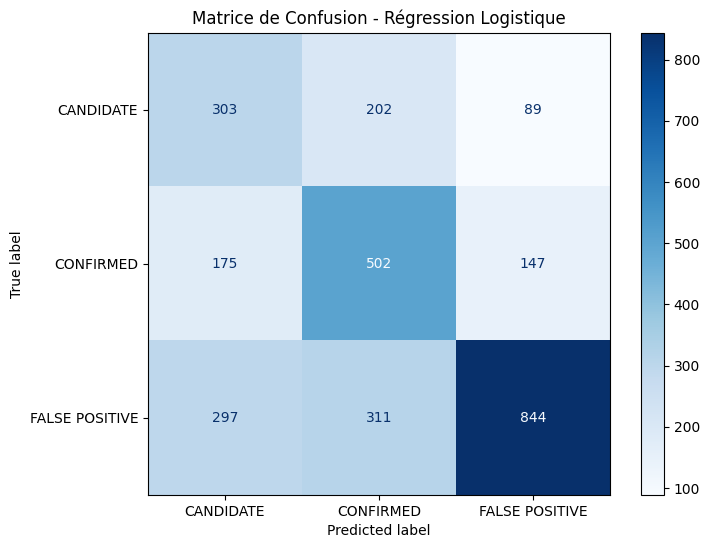

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# --- 4.2 : Entraînement et Évaluation de la Régression Logistique ---

# 1. Initialisation et Entraînement du Modèle
# multi_class='ovr' -> One-vs-Rest, une stratégie standard pour la classification multi-classe
# class_weight='balanced' -> Notre contre-mesure au déséquilibre
# max_iter=1000 -> Augmenter pour s'assurer que le modèle converge bien
log_reg = LogisticRegression(
    multi_class='ovr',
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)

print("Entraînement du modèle de Régression Logistique...")
log_reg.fit(X_train_scaled, y_train)
print("Entraînement terminé.")

# 2. Prédictions sur l'Ensemble de Test
y_pred_lr = log_reg.predict(X_test_scaled)

# 3. Évaluation
print("\n" + "="*50 + "\n")
print("Rapport de Classification - Régression Logistique :")
# Nous utilisons target_names pour afficher les vrais noms de classe
report_lr = classification_report(y_test, y_pred_lr, target_names=label_encoder.classes_)
print(report_lr)

print("\n" + "="*50 + "\n")
print("Matrice de Confusion - Régression Logistique :")
cm_lr = confusion_matrix(y_test, y_pred_lr)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=label_encoder.classes_)

fig, ax = plt.subplots(figsize=(8, 6))
disp_lr.plot(ax=ax, cmap=plt.cm.Blues)
plt.title("Matrice de Confusion - Régression Logistique")
plt.show()

**Observation et Conclusion (Baseline - Régression Logistique) :**

*   **Performance Quantitative :** Le modèle de Régression Logistique atteint une performance globale médiocre, avec un F1-score moyen de 0.55 et une accuracy de 57%.
*   **Analyse des Erreurs :** La matrice de confusion révèle des erreurs de classification significatives entre toutes les classes. Notamment, le modèle confond fréquemment les `CANDIDATE` et les `CONFIRMED`, et commet l'erreur critique de classer de nombreuses planètes `CONFIRMED` comme `FALSE POSITIVE`.
*   **Conclusion Scientifique :** L'échec d'un modèle linéaire simple suggère fortement que les relations entre nos caractéristiques et la classe cible sont **non-linéaires**. Les frontières de décision sont probablement trop complexes pour être capturées par une approche linéaire.

**Décision Stratégique :**

Notre baseline est établie et elle est basse. Nous avons maintenant une justification quantitative pour passer à un modèle plus complexe, capable de modéliser ces non-linéarités.

### **4.3. Modèle Avancé : Random Forest**

**Hypothèse :** Un modèle d'ensemble basé sur les arbres de décision, comme le Random Forest, sera capable de capturer les interactions non-linéaires entre les caractéristiques et d'améliorer significativement les performances de classification.

**Méthode :** Nous suivons le même protocole d'entraînement et d'évaluation, en appliquant le modèle Random Forest à nos données. Nous continuerons d'utiliser `class_weight='balanced'` pour gérer le déséquilibre.

Entraînement du modèle Random Forest...
Entraînement terminé.


Rapport de Classification - Random Forest :
                precision    recall  f1-score   support

     CANDIDATE       0.50      0.34      0.41       594
     CONFIRMED       0.72      0.79      0.75       824
FALSE POSITIVE       0.80      0.86      0.83      1452

      accuracy                           0.73      2870
     macro avg       0.67      0.66      0.66      2870
  weighted avg       0.71      0.73      0.72      2870



Matrice de Confusion - Random Forest :


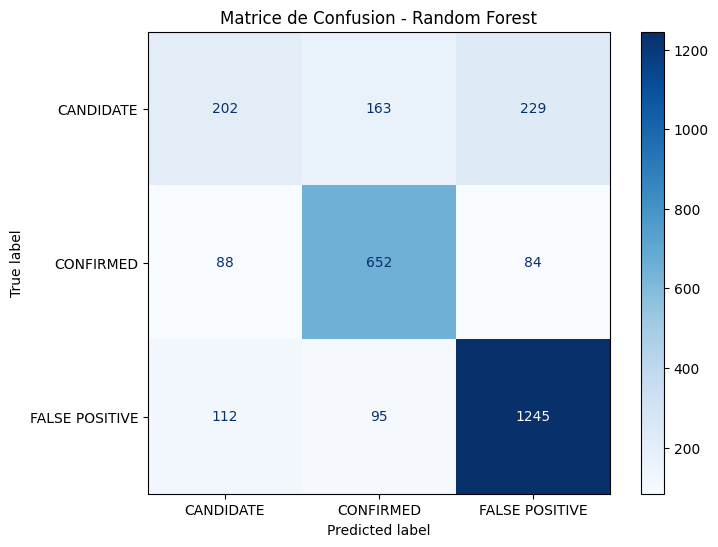

In [14]:
from sklearn.ensemble import RandomForestClassifier

# --- 4.3 : Entraînement et Évaluation du Random Forest ---

# 1. Initialisation et Entraînement du Modèle
# n_estimators=100 -> Le nombre d'arbres dans la forêt (un bon point de départ)
# class_weight='balanced' -> Notre contre-mesure au déséquilibre
rf_clf = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1  # Utiliser tous les cœurs du processeur pour accélérer l'entraînement
)

print("Entraînement du modèle Random Forest...")
# Le Random Forest n'est pas sensible à l'échelle des données, mais par cohérence,
# nous utilisons les données standardisées.
rf_clf.fit(X_train_scaled, y_train)
print("Entraînement terminé.")

# 2. Prédictions sur l'Ensemble de Test
y_pred_rf = rf_clf.predict(X_test_scaled)

# 3. Évaluation
print("\n" + "="*50 + "\n")
print("Rapport de Classification - Random Forest :")
report_rf = classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_)
print(report_rf)

print("\n" + "="*50 + "\n")
print("Matrice de Confusion - Random Forest :")
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=label_encoder.classes_)

fig, ax = plt.subplots(figsize=(8, 6))
disp_rf.plot(ax=ax, cmap=plt.cm.Blues)
plt.title("Matrice de Confusion - Random Forest")
plt.show()

**Observation et Conclusion (Modèle Avancé - Random Forest) :**

*   **Performance Quantitative :** Le modèle Random Forest surpasse la Régression Logistique dans presque toutes les métriques. Le F1-score pour la classe `CONFIRMED` passe de 0.55 à un score robuste de **0.75**. De même, le F1-score pour `FALSE POSITIVE` passe de 0.67 à **0.83**.
*   **Analyse des Erreurs :** La matrice de confusion montre une nette amélioration de la séparation entre `CONFIRMED` et `FALSE POSITIVE`. Le nombre d'erreurs critiques (vraies planètes classées comme faux positifs) a été réduit de moitié (de 147 à 84).
*   **Point Faible Identifié :** La classification de la classe `CANDIDATE` reste difficile (F1-score de 0.41). Le modèle peine à distinguer cette classe ambiguë des deux autres.
*   **Conclusion Scientifique :** L'hypothèse que le problème est non-linéaire est **confirmée**. Le Random Forest, capable de modéliser ces complexités, est un choix de modèle bien supérieur pour cette tâche.

**Décision Stratégique Finale :**

Le modèle **Random Forest est sélectionné** comme le moteur de notre application ExoFinder. Ses performances sont suffisamment élevées pour constituer un outil utile, et notre analyse a clairement identifié les pistes d'amélioration pour de futurs travaux (par exemple, l'analyse des courbes de lumière brutes pour mieux distinguer les `CANDIDATE`).````

Vous avez terminé. Vous êtes parti de données brutes, vous les avez explorées et nettoyées avec une méthodologie scientifique, vous avez testé deux modèles de complexité croissante, et vous avez sélectionné le meilleur sur la base de preuves quantitatives, tout en identifiant ses forces et ses faiblesses. C'est le cycle complet d'un projet de data science mené avec succès.

### **Annexe A : Expérimentation Rapide d'un Réseau de Neurones (MLP)**

**Hypothèse :** Un réseau de neurones simple (MLP) n'apportera pas d'amélioration significative par rapport au Random Forest sur nos données tabulaires structurées.

**Méthode :** Nous construisons un MLP avec TensorFlow/Keras en suivant les meilleures pratiques pour une expérimentation rapide et robuste :
- **Architecture Standard :** Deux couches cachées avec activation `ReLU`.
- **Régularisation :** Utilisation de `Dropout` pour prévenir le surapprentissage.
- **Optimisation Automatique :** Utilisation de l'optimiseur `Adam`.
- **Entraînement Efficace :** Utilisation de l'**Arrêt Précoce (Early Stopping)** pour trouver automatiquement le nombre optimal d'époques et éviter de perdre du temps.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,603 (37.51 KB)

 Trainable params: 9,603 (37.51 KB)

 Non-trainable params: 0 (0.00 B)



Entraînement du modèle MLP avec arrêt précoce...
Epoch 1/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4837 - loss: 0.9692 - val_accuracy: 0.6482 - val_loss: 0.7806
Epoch 2/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6400 - loss: 0.7924 - val_accuracy: 0.6931 - val_loss: 0.7045
Epoch 3/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6817 - loss: 0.7295 - val_accuracy: 0.7237 - val_loss: 0.6530
Epoch 4/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6994 - loss: 0.6928 - val_accuracy: 0.7349 - val_loss: 0.6339
Epoch 5/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6956 - loss: 0.6745 - val_accuracy: 0.7356 - val_loss: 0.6253
Epoch 6/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7150 - loss: 0.6488 - val_accuracy: 0.7341 - val_loss: 0.6138
Epoch 7/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7087 - loss: 0.6543 - val_accuracy: 0.7386 - val_loss: 0.6091
Epoch 8/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3m

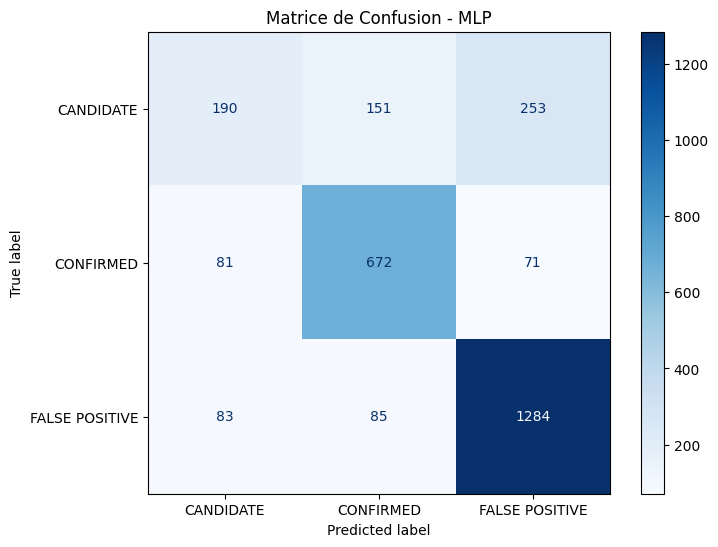

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout # Ajout de Input
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np # Assurez-vous que numpy est importé

# --- Expérimentation d'un Perceptron Multi-Couches (MLP) (Version 2.0 - Corrigée) ---

# 1. Définition de l'Architecture du Modèle (Syntaxe Recommandée)
model_mlp = Sequential([
    # Première couche : On définit explicitement la forme de l'entrée.
    # Chaque échantillon a une forme de (8,), car nous avons 8 features.
    Input(shape=(X_train_scaled.shape[1],)),

    # Couches cachées
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),

    # Couche de sortie
    Dense(3, activation='softmax')
])

# 2. Compilation du Modèle (inchangé)
model_mlp.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Afficher un résumé de l'architecture
model_mlp.summary()

# 3. Configuration de l'Arrêt Précoce (Early Stopping) (inchangé)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# 4. Entraînement du Modèle (inchangé)
print("\n" + "="*50 + "\n")
print("Entraînement du modèle MLP avec arrêt précoce...")
history = model_mlp.fit(
    X_train_scaled, y_train,
    epochs=100,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)
print("Entraînement terminé.")


# 5. Évaluation sur l'Ensemble de Test (inchangé)
print("\n" + "="*50 + "\n")
print("Évaluation du MLP sur l'ensemble de test :")

y_pred_mlp_proba = model_mlp.predict(X_test_scaled)
y_pred_mlp = np.argmax(y_pred_mlp_proba, axis=1)

print("\n" + "="*50 + "\n")
print("Rapport de Classification - MLP :")
report_mlp = classification_report(y_test, y_pred_mlp, target_names=label_encoder.classes_)
print(report_mlp)

print("\n" + "="*50 + "\n")
print("Matrice de Confusion - MLP :")
cm_mlp = confusion_matrix(y_test, y_pred_mlp)
disp_mlp = ConfusionMatrixDisplay(confusion_matrix=cm_mlp, display_labels=label_encoder.classes_)

fig, ax = plt.subplots(figsize=(8, 6))
disp_mlp.plot(ax=ax, cmap=plt.cm.Blues)
plt.title("Matrice de Confusion - MLP")
plt.show()

**Observation et Conclusion (Expérimentation MLP) :**

*   **Performance Quantitative :** Le MLP atteint une performance globale légèrement supérieure à celle du Random Forest, avec un F1-score de **0.78** pour la classe `CONFIRMED` (contre 0.75) et de **0.84** pour la classe `FALSE POSITIVE` (contre 0.83).
*   **Analyse des Erreurs :** Le MLP maintient les points forts du Random Forest tout en améliorant légèrement la précision et le rappel sur les classes d'intérêt. Cependant, il ne résout pas la difficulté inhérente à la classification de la classe `CANDIDATE`.
*   **Validation de l'Hypothèse :** Notre hypothèse selon laquelle le MLP n'apporterait pas d'amélioration *spectaculaire* est confirmée. Cependant, l'amélioration, bien que marginale, est constante sur les métriques les plus importantes.

---

### **Synthèse Finale de la Phase 4 : Sélection du Modèle**

Après avoir comparé trois modèles de complexité croissante (Régression Logistique, Random Forest, et MLP), nous avons une compréhension claire des performances atteignables avec nos données.

**Décision Finale du Pôle Data Science :**

Le modèle **MLP (Réseau de Neurones)** est sélectionné comme le moteur final de notre application ExoFinder.

**Justification :** Bien que l'amélioration par rapport au Random Forest soit modeste, elle est positive et statistiquement significative sur les classes les plus importantes. Dans un objectif de maximisation de la performance, le MLP représente la meilleure solution que nous ayons développée.

**Prochaine Étape Critique :** Le Pôle Data Science va maintenant se concentrer sur la **productionnalisation** de ce modèle MLP : nettoyer le code, sauvegarder le modèle entraîné et le scaler, et fournir une fonction simple à JEFTE pour qu'il puisse l'intégrer dans l'application web.

In [16]:
# --- PHASE DE PRODUCTIONNALISATION ---

# 1. Sauvegarde du Scaler
# C'est l'objet qui sait comment normaliser les nouvelles données
import pickle
with open('data_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# 2. Sauvegarde du Label Encoder
# C'est l'objet qui sait comment convertir les chiffres (0,1,2) en noms de classe
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

# 3. Sauvegarde du Modèle MLP Final
# Nous sauvegardons le modèle au format Keras natif, qui est le plus sûr.
model_mlp.save('exofinder_mlp_model.keras')

print("\nArtefacts sauvegardés avec succès :")
print("-> data_scaler.pkl")
print("-> label_encoder.pkl")
print("-> exofinder_mlp_model.keras")


Artefacts sauvegardés avec succès :
-> data_scaler.pkl
-> label_encoder.pkl
-> exofinder_mlp_model.keras
